In [1]:
import pandas as pd
import numpy as np
import re
from sklearn import tree, metrics, decomposition, ensemble, model_selection
from sklearn import naive_bayes, linear_model, svm
from utils import clean
%matplotlib inline

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_df = pd.read_csv('test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
df = pd.concat([train_df, test_df],ignore_index=True)
df.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309
1308,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668


In [5]:
df.loc[:,'Title'] = df.Name.apply(lambda x: re.match(pattern='.+, (.+?)\..+', string=x)[1])

In [6]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [7]:
df.Title.value_counts().head()

Mr        757
Miss      260
Mrs       197
Master     61
Rev         8
Name: Title, dtype: int64

In [8]:
title_dict = {'Miss': ['Miss', 'Ms', 'Mlle'],
             'Mrs': ['Mrs', 'Mme'],
             'Mr': ['Mr'],
              'Master': ['Master'],
             'rare':['Lady', 'the Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']}

In [9]:
for key, values in title_dict.items():
    df.Title.replace(values, key, inplace=True)

In [10]:
df.Title.value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
rare       29
Name: Title, dtype: int64

In [11]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [12]:
df.Age.isnull().value_counts()

False    1046
True      263
Name: Age, dtype: int64

In [13]:
title_mean_age = {}
for i in df.Title.unique(): title_mean_age[i] = df[df['Title']==i].Age.mean()
for i in df[df.Age.isnull()].index: df.loc[i,'Age'] = title_mean_age[df.loc[i,'Title']]

In [14]:
df.loc[:,'Age_Range'] = pd.cut(df.Age, bins=np.append([0,12,25,35,45], float('inf')))

In [15]:
df.Age_Range.value_counts()

(25.0, 35.0]    457
(12.0, 25.0]    400
(35.0, 45.0]    194
(45.0, inf]     156
(0.0, 12.0]     102
Name: Age_Range, dtype: int64

In [16]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Age_Range
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,"(12.0, 25.0]"
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,"(35.0, 45.0]"
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,"(25.0, 35.0]"
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,"(25.0, 35.0]"
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,"(25.0, 35.0]"


In [36]:
df.loc[:,'family_size'] = df.SibSp + df.Parch

In [37]:
df.Ticket.nunique()

929

In [38]:
df.Sex.value_counts(dropna=False)

male      843
female    466
Name: Sex, dtype: int64

In [39]:
df.Pclass.value_counts(dropna=False)

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [20]:
df.Cabin.value_counts(dropna=False).head()

NaN                1014
C23 C25 C27           6
B57 B59 B63 B66       5
G6                    5
C78                   4
Name: Cabin, dtype: int64

In [21]:
df.Embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: Embarked, dtype: int64

In [22]:
df.loc[df.Embarked.isnull(),'Embarked'] = 'S'

Cabin doesn't indicate anything as most values are null. 

Similarly the ticket feature has too many unique values which do not convey anything.

**Exploratory Data Analysis:**

In [40]:
train_df = df[~df.Survived.isnull()]
test_df = df[df.Survived.isnull()]

In [41]:
def percent_survivor(index, df=train_df):
    df = pd.pivot_table(df, index=index, aggfunc={'Survived':'sum','PassengerId':'count'})
    df.loc[:,'Percentage_Survivors'] = df.Survived.div(df.PassengerId)
    return df.Percentage_Survivors

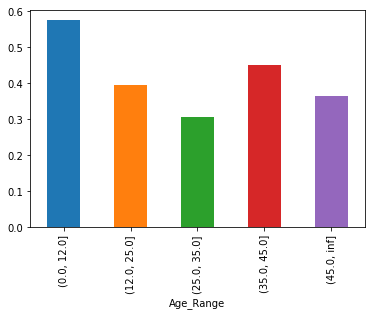

In [42]:
percent_survivor('Age_Range').plot(kind='bar')

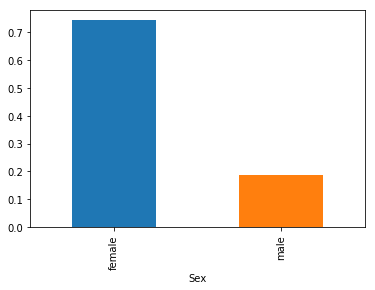

In [43]:
percent_survivor('Sex').plot(kind='bar')

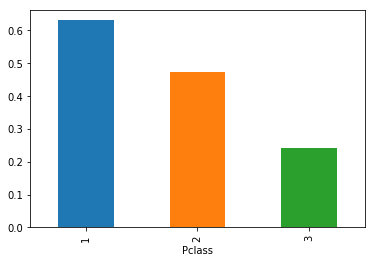

In [44]:
percent_survivor('Pclass').plot(kind='bar')

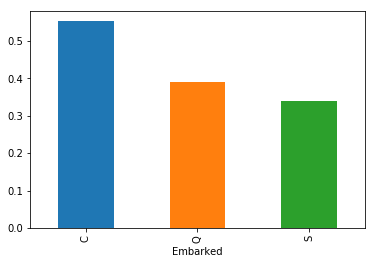

In [45]:
percent_survivor('Embarked').plot(kind='bar')

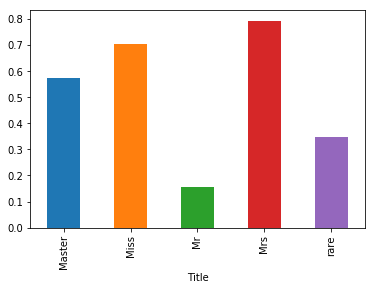

In [46]:
percent_survivor('Title').plot(kind='bar')

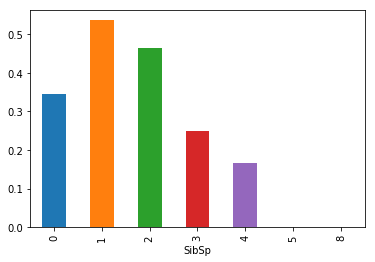

In [47]:
percent_survivor('SibSp').plot(kind='bar')

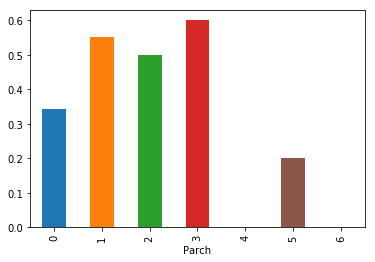

In [48]:
percent_survivor('Parch').plot(kind='bar')

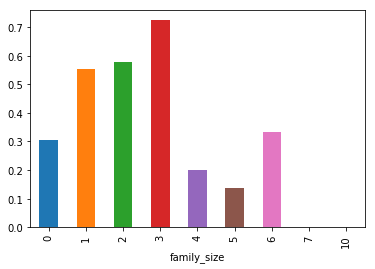

In [50]:
percent_survivor('family_size').plot(kind='bar')

In [52]:
train_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Age_Range,family_size
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,"(12.0, 25.0]",1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,"(35.0, 45.0]",1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,"(25.0, 35.0]",0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,"(25.0, 35.0]",1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,"(25.0, 35.0]",0


In [90]:
train_df = train_df[['Age','Embarked','Fare','Pclass','Sex','Title','family_size']]

In [97]:
def one_hot_encoder(df, label):
    df_ = df.copy()
    for i in df_[label].unique():
        df_.loc[:, label+'_'+i] = 0
        df_.loc[df_[label]==i, label+'_'+i]=1
    return df_

In [98]:
train_df.head()

,Age,Embarked,Fare,Pclass,Sex,Title,family_size
0,22.0,S,7.2500,3,male,0,1
1,38.0,C,71.2833,1,female,0,1
2,26.0,S,7.9250,3,female,0,0
3,35.0,S,53.1000,1,female,0,1
4,35.0,S,8.0500,3,male,0,0


In [99]:
temp = one_hot_encoder(train_df, 'Embarked')

In [100]:
temp.head()

,Age,Embarked,Fare,Pclass,Sex,Title,family_size,Embarked_S,Embarked_C,Embarked_Q
0,22.0,S,7.2500,3,male,0,1,1,0,0
1,38.0,C,71.2833,1,female,0,1,0,1,0
2,26.0,S,7.9250,3,female,0,0,1,0,0
3,35.0,S,53.1000,1,female,0,1,1,0,0
4,35.0,S,8.0500,3,male,0,0,1,0,0


In [55]:
pca = decomposition.PCA(n_components = 6)
reduced_features = pca.fit_transform(train_df)

ValueError: could not convert string to float: 'Mr'

In [ ]:
pca = decomposition.PCA(n_components = 6)
reduced_features = pca.fit_transform(train_df)
reduced_test = pca.transform(features_test)

In [ ]:
#====================== AdaBoost (74.16% accuracy)=============================
tree_clf = tree.DecisionTreeClassifier(min_samples_split = 2, max_depth=4)
abc = ensemble.AdaBoostClassifier(base_estimator = tree_clf, n_estimators=80, learning_rate=0.7)
parameters = {'n_estimators': [90], 'learning_rate': [0.9]}
clf = model_selection.GridSearchCV(abc, param_grid = parameters)
clf.fit(reduced_features, labels_train)
output = clf.predict(reduced_test)
accuracy_score = metrics.accuracy_score(output,answers['Survived'].values)

In [ ]:
#================== Logistic Regression (78.7% accuracy) =====================
clf = linear_model.LogisticRegression(C=100,solver='newton-cg',multi_class='multinomial')
clf.fit(reduced_features, labels_train)
output = clf.predict(reduced_test)
accuracy_score = metrics.accuracy_score(output, answers['Survived'].values)

In [ ]:
#=========================== SVM (77.75% accuracy) ============================
params = {'C':[0.001,0.01,0.1,1,10,100], 'gamma':[0.001,0.01,0.1,1,10,100]}
clf = model_selection.GridSearchCV(svm.SVC(), param_grid = params)
clf.fit(reduced_features, labels_train)
output = clf.predict(reduced_test)
accuracy_score = metrics.accuracy_score(output, answers['Survived'].values)

In [ ]:
#============================== Tree =========================================
params = {"max_depth": np.arange(1, 6), "max_features": np.arange(1, 7),
         "min_samples_leaf": np.arange(1, 6), "criterion": ["gini","entropy"]}
clf = model_selection.GridSearchCV(tree.DecisionTreeClassifier(),param_grid = params)
clf.fit(reduced_features, labels_train)
output = clf.predict(reduced_test)
accuracy_score = metrics.accuracy_score(output, answers['Survived'].values)

In [ ]:
#======================== RandomForestClassifier =============================
params = {'n_estimators':[100,120], 'max_features':[5,6,7]}
clf = model_selection.GridSearchCV(ensemble.RandomForestClassifier(),param_grid = params)
clf.fit(reduced_features, labels_train)
output = clf.predict(reduced_test)
accuracy_score = metrics.accuracy_score(output, answers['Survived'].values)
#=============================================================================

In [ ]:
#============================ Naive Bayes ====================================
clf = naive_bayes.GaussianNB()
clf.fit(reduced_features, labels_train)
output = clf.predict(reduced_test)
accuracy_score = metrics.accuracy_score(output, answers['Survived'].values)
#=============================================================================